<a href="https://colab.research.google.com/github/francisbonheur/alyra_projet_deep_learning/blob/main/ML_detection_valeur_famille.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning : prédiction de la valeur humaine "famille et tradition"

A partir des données issues de l'European Social Survey.  
Dataset :  
 - [European social survey dataset generator](https://ess.sikt.no/en/data-builder/?rounds=0+1+2+3+4+5+6+7+8+9+10+11&seriesVersion=920&tab=download&variables=1.0.40+2.0.64_65_68+3.1_87+4.0.8_30_31_47_74_76_90-93_132+5.4_6_8_12_16)

## Chargement des frameworks python

In [471]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from rpy2.robjects.packages import importr

from sklearn.model_selection import train_test_split

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Chargement du dataset

In [472]:
# Lecture du dataset (fichier CSV)
# L'index est composé des colonnes qui permettent d'identifier de façon unique l'individu
# 0 : name - Title of dataset
# 1 : essround - ESS round
# 2 : edition - Edition
# 3 : proddate - Production date
# 4 : idno - Respondent's identification number
# 5 : cntry - Country
df = pd.read_csv('sample_data/ESSfull-20251120.csv', header=0, index_col=[0,1,2,3,4,5])

# Vérification du nombre de doublons
print(f"Nombre de doublons : {df.index.duplicated().sum()}")

# Ces colonnes decrive le dataset et ne représentent pas des features
ess_description_columns_name = ['dweight', 'pspwght', 'pweight', 'anweight', 'prob', 'stratum', 'psu']

available_labels_names = ['ipbhprp', 'impfun', 'imptrad', 'imprich', 'impfree']

label_name = 'imptrad'

available_labels_names.remove(label_name)

# On ne conserve que les données utiles pour la prédiction
data_without_description = df.drop(columns=ess_description_columns_name, axis=1)

# On se conserve que le label à prédire "famille et tradition"
data_without_useless_labels = data_without_description.drop(columns=available_labels_names, axis=1)

data_without_useless_labels.info()


Nombre de doublons : 1
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 540671 entries, ('ESS1e06_7', np.int64(1), np.float64(6.7), '23.11.2023', np.int64(1), 'AT') to ('ESS11e04', np.int64(11), np.float64(4.0), '19.11.2025', np.int64(273747), 'UA')
Data columns (total 30 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ppltrst   540671 non-null  int64  
 1   implvdm   114358 non-null  float64
 2   lrscale   540671 non-null  int64  
 3   polintr   540671 non-null  int64  
 4   trstlgl   540671 non-null  int64  
 5   trstplc   540671 non-null  int64  
 6   trstplt   540671 non-null  int64  
 7   imwbcnt   540671 non-null  int64  
 8   volunfp   109801 non-null  float64
 9   lrnobed   109801 non-null  float64
 10  loylead   109801 non-null  float64
 11  rlgdgr    540671 non-null  int64  
 12  rlgdnm    527156 non-null  float64
 13  sclmeet   540671 non-null  int64  
 14  wrclmch   154188 non-null  float64
 15  gndr      540671 non-null  int6

## Nettoyage des données

### Suppression des valeurs représentant une "non réponse"

In [473]:
# Matrice des noms de colonnes et des valeurs à remplacer
missing_values_dict = {
    'polintr': [7, 8, 9],
    'rlgdgr': [77, 88, 99],
    'rlgdnm': [77, 88, 99],
    'sclmeet': [77, 88, 99],
    'gndr': [9],
    'agea': [999],
    'chldhm': [9], # impossible de faire la différence avec le cas "9 enfants à la maison
    'edulvla': [77, 88, 99],
    'edulvlb': [7777, 8888, 9999],
    'emplrel': [7, 8, 9],
    'isco08': [66666, 77777, 88888, 99999],
    'iscoco': [66666, 77777, 88888, 99999],
    'marital': [7, 8, 9],
    'maritala': [77, 88, 99],
    'maritalb': [77, 88, 99],
    'marsts': [66, 77, 88, 99],
    'tporgwk': [66, 77, 88, 99],
    'imptrad': [7, 8, 9],
    'impfree': [7, 8, 9],
    'imprich': [7, 8, 9],
    'ipbhprp': [7, 8, 9],
    'impfun' : [7, 8, 9],
    'ppltrst' : [77,88,99],
    'implvdm' : [77,88,99],
    'lrscale' : [77,88,99],
    'trstlgl' :  [77,88,99],
    'trstplc' : [77,88,99],
    'trstplt' : [77,88,99],
    'imwbcnt' :  [77,88,99],
    'volunfp' : [7,8,9],
    'lrnobed' : [7,8,9],
    'loylead' : [7,8,9],
    'wrclmch' : [6,7,8,9],
    'domicil' : [7,8,9]
}


data_without_no_reponse_codes = data_without_useless_labels.replace(missing_values_dict, np.nan)

data_without_no_reponse_codes.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 540671 entries, ('ESS1e06_7', np.int64(1), np.float64(6.7), '23.11.2023', np.int64(1), 'AT') to ('ESS11e04', np.int64(11), np.float64(4.0), '19.11.2025', np.int64(273747), 'UA')
Data columns (total 30 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ppltrst   538613 non-null  float64
 1   implvdm   112311 non-null  float64
 2   lrscale   464019 non-null  float64
 3   polintr   538935 non-null  float64
 4   trstlgl   526829 non-null  float64
 5   trstplc   534047 non-null  float64
 6   trstplt   529844 non-null  float64
 7   imwbcnt   514662 non-null  float64
 8   volunfp   109068 non-null  float64
 9   lrnobed   108499 non-null  float64
 10  loylead   106473 non-null  float64
 11  rlgdgr    535309 non-null  float64
 12  rlgdnm    524340 non-null  float64
 13  sclmeet   537607 non-null  float64
 14  wrclmch   150111 non-null  float64
 15  gndr      539704 non-null  float64
 16  agea      5369

### Suppression des lignes sans label

In [474]:
# Suppression des lignes sans label
data_no_empty_label = data_without_no_reponse_codes.dropna(subset=[label_name])

### Simplification du problème (2 classes au lieu de 6)

In [475]:
tradition_value_sensibility_matrix = {
    label_name : {
        1: 0,
        2: 0,
        3: 0,
        4: 1,
        5: 1,
        6: 1,
    }
}

data = data_no_empty_label.replace(tradition_value_sensibility_matrix)

data[label_name].unique()

array([0., 1.])

### Données manquantes par lignes

In [476]:
# Calcul du pourcentage de valeurs manquantes par ligne
missing_value_min_percent = min(data.isnull().mean(axis=1) * 100)

if missing_value_min_percent > 15:
    print("Toutes les lignes ont plus de 15% de valeurs manquantes. La suppression est immossible on privilégie l'imputation")



Toutes les lignes ont plus de 15% de valeurs manquantes. La suppression est immossible on privilégie l'imputation


#### Données manquantes par colonne

In [477]:
#Calcul du pourcentage de valeurs manquantes par colonne
print("Pourcentage de valeurs manquantes par colonne :")
missing_values_percent_per_col = data.isnull().mean() * 100

# Affichage des colonnes avec plus de 50 % de valeurs manquantes
for col, percent in missing_values_percent_per_col.items():
    if percent > 50:
        print(f"{col}: {percent:.2f}%")


Pourcentage de valeurs manquantes par colonne :
implvdm: 80.24%
volunfp: 91.84%
lrnobed: 91.85%
loylead: 92.01%
wrclmch: 82.63%
edulvla: 60.60%
isco08: 56.15%
iscoco: 55.43%
marital: 82.58%
maritala: 79.12%
marsts: 69.44%


<ins>Traitement des colonnes isco08 et iscoco</ins>  
- la colonne isco08 donne la profession du sondé dans le référentiel ISCO-08
- la colonne iscoco donne la profession du sondé dans le référentiel ISCO-88  
- Les deux colonnes sont complémentaires.  
  - Conversion des données de la colonne isco08 dans le référentiel ISCO-88 (Utilisation d'une fonction R [ISCO08ConveRsions](https://cran.r-project.org/web/packages/ISCO08ConveRsions/index.html) )
  - Fusion des 2 colonnes dans une nouvelle colonne "occupation"

In [478]:
# Load R
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [479]:
# indicate that you're running R code
%%R

# Install if it's your first time to run
install.packages("ISCO08ConveRsions")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/ISCO08ConveRsions_0.2.0.tar.gz'
Content type 'application/x-gzip' length 22479 bytes (21 KB)
downloaded 21 KB


The downloaded source packages are in
	‘/tmp/RtmpWJ2swb/downloaded_packages’


In [480]:
# Nombre de lignes avec les deux colonnes isco08 et iscoco manquantes
missing_isco08_iscoco = data[data['isco08'].isnull() & data['iscoco'].isnull()]
print(f"Nombre de lignes sans l'information de la profession (colonnes isco08 et iscoco vides) : {len(missing_isco08_iscoco)}")

# Les deux colonnes sont complémentaires, on va faire du feature engineering pour créer une nouvelle colonne 'occupation' qui regroupe les deux informations

# installation du package R ISCO08ConveRsions nécessaire : install.packages("ISCO08ConveRsions")
ISCO08ConveRsions = importr('ISCO08ConveRsions')


# Méthode conversion des code professions ISCO 08 en ISCO 88
def isco08_to_isco88(code):
    try:
        # La fonction R ne sais pas convertir le code ISCO 08 '0', on le gère nous même
        if code == '0000':
            return code

        return ISCO08ConveRsions.isco08toisco88(code)[0]
    except:
        print(f"Conversion impossible pour le code ISCO 08 : {code}")
        return np.nan

# Get ISO code as string with leading zeros
def get_code(code_as_int):
    if pd.isnull(code_as_int):
        return np.nan

    return str(code_as_int).split('.')[0].zfill(4)

data.loc[:, 'occupation_code'] = data.apply(
    lambda row: isco08_to_isco88(get_code(row['isco08'])) if pd.notnull(row['isco08']) else get_code(row['iscoco']),
    axis=1
)

# Nombre de lignes avec la colonne occupation manquante
missing_occupation = data[data['occupation_code'].isnull()]
print(f"Nombre de lignes sans l'information de la profession après feature engineering (colonne occupation vide) : {len(missing_occupation)}")

data['occupation'] = data['occupation_code'].str[0]

data = data.drop(columns=['occupation_code', 'isco08', 'iscoco'], axis=1)

data

Nombre de lignes sans l'information de la profession (colonnes isco08 et iscoco vides) : 52378


/tmp/ipython-input-3647001507.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[:, 'occupation_code'] = data.apply(


Nombre de lignes sans l'information de la profession après feature engineering (colonne occupation vide) : 52378


ppltrst  implvdm  lrscale  \
name       essround edition proddate   idno  cntry                              
ESS1e06_7  1        6.7     23.11.2023 1     AT         7.0      NaN      6.0   
                                       2     AT         6.0      NaN      6.0   
                                       3     AT         0.0      NaN      5.0   
                                       4     AT         8.0      NaN      5.0   
                                       6     AT         8.0      NaN      5.0   
...                                                     ...      ...      ...   
ESS10e03_2 10       3.2     02.11.2023 27808 SK         5.0     10.0      9.0   
                                       27826 SK         7.0     10.0     10.0   
                                       27834 SK         0.0      8.0      5.0   
                                       27846 SK         2.0     10.0      2.0   
                                       27858 SK         5.0      7.0      7.0   

                                                    polintr  trstlgl  trstplc  \
name       essround edition proddate   idno  cntry                              
ESS1e06_7  1        6.7     23.11.2023 1     AT         3.0     10.0     10.0   
                                       2     AT         1.0      8.0      5.0   
                                       3     AT         2.0      4.0      8.0   
                                       4     AT         2.0     10.0      9.0   
                                       6     AT         3.0      7.0      4.0   
...                                                     ...      ...      ...   
ESS10e03_2 10       3.2     02.11.2023 27808 SK         4.0      2.0      9.0   
                                       27826 SK         2.0      7.0      8.0   
                                       27834 SK         2.0      1.0      0.0   
                                       27846 SK         4.0      0.0      8.0   
                                       27858 SK         4.0      6.0      7.0   

                                                    trstplt  imwbcnt  volunfp  \
name       essround edition proddate   idno  cntry                              
ESS1e06_7  1        6.7     23.11.2023 1     AT         0.0      7.0      NaN   
                                       2     AT         0.0      5.0      NaN   
                                       3     AT         2.0      5.0      NaN   
                                       4     AT         4.0     10.0      NaN   
                                       6     AT         4.0      NaN      NaN   
...                                                     ...      ...      ...   
ESS10e03_2 10       3.2     02.11.2023 27808 SK         7.0      6.0      2.0   
                                       27826 SK         8.0      6.0      2.0   
                                       27834 SK         1.0      2.0      2.0   
                                       27846 SK         7.0      1.0      1.0   
                                       27858 SK         6.0      4.0      2.0   

                                                    lrnobed  ...  edulvla  \
name       essround edition proddate   idno  cntry           ...            
ESS1e06_7  1        6.7     23.11.2023 1     AT         NaN  ...      3.0   
                                       2     AT         NaN  ...      3.0   
                                       3     AT         NaN  ...      2.0   
                                       4     AT         NaN  ...      5.0   
                                       6     AT         NaN  ...      3.0   
...                                                     ...  ...      ...   
ESS10e03_2 10       3.2     02.11.2023 27808 SK         1.0  ...      NaN   
                                       27826 SK         3.0  ...      NaN   
                                       27834 SK         2.0  ...      NaN   
                                       2784

<ins>Traitement des colonnes edulvla et edulvlb</ins>  
- la colonne edulvla donne le niveau d'étude dans le référentiel ISCED (5 niveaux)
- la collone edulvlb donne le niveau d'étude dans le référentiel ISCED (description détaillé)
- Les deux colonnes sont complémentaires
  - Conversion des données de la colonnes edulvlb dans le référentiel ISCED "simplifié" (création d'une matrice mapping à partir de la documentation)
  - Fusion des deux colonnes dans une nouvelle colonne "education"

|       |Inclassable|ISCED 0-1|ISCED 2|ISCED 3|ISCED 4|ISCED 5-6|Other|
|-------|-----------|---------|-------|-------|-------|---------|-----|
|edulvla|          0|        1|                      2|                          3|                  4|        5| 55|
|edulvlb|           |    0,113|129,212,213<br>221,222,223|229,311,312<br>313,321,322,323|412,413,421<br>422,423|510,520,610<br>620,710,720,800|5555|

In [481]:
# Nombre de lignes avec les deux colonnes edulvla et edulvla manquantes
missing_edulvla_edulvlb = data[data['edulvla'].isnull() & data['edulvlb'].isnull()]
print(f"Nombre de lignes sans l'information du niveau d'étude (colonnes edulvla et edulvlb vides) : {len(missing_edulvla_edulvlb)}")

# Affichage des valeurs uniques de la colonne edulvlb avant le mapping
print("Valeurs uniques de la colonne edulvlb avant le mapping :")
print(data['edulvlb'].unique())

education_mapping_matrix = {
    'edulvlb': {
        0: 1,
        113: 1,
        129: 2,
        212: 2,
        213: 2,
        221: 2,
        222: 2,
        223: 2,
        229: 3,
        311: 3,
        312: 3,
        313: 3,
        321: 3,
        322: 3,
        323: 3,
        412: 4,
        413: 4,
        421: 4,
        422: 4,
        423: 4,
        510: 5,
        520: 5,
        610: 5,
        620: 5,
        710: 5,
        720: 5,
        800: 5,
        5555: 55
    }
}

data = data.replace(education_mapping_matrix)

# Affichage des valeurs uniques de la colonne edulvlb après le mapping
print("Valeurs uniques de la colonne edulvlb après le mapping :")
print(data['edulvlb'].unique())

# Création de la colonne education qui regroupe les deux colonnes edulvla et edulvlb
data['education'] = data.apply(
    lambda row: row['edulvla'] if pd.notnull(row['edulvla']) else get_code(row['edulvlb']),
    axis=1
)

data = data.drop(columns=['edulvla', 'edulvlb'], axis=1)

# Nombre de lignes avec la colonne occupation manquante
missing_education = data[data['education'].isnull()]
print(f"Nombre de lignes sans l'information du niveau d'étude après feature engineering (colonne education vide) : {len(missing_education)}")



Nombre de lignes sans l'information du niveau d'étude (colonnes edulvla et edulvlb vides) : 1219
Valeurs uniques de la colonne edulvlb avant le mapping :
[  nan  323.  610.  321.  720.  313.  113.  213.  421.  222.  710.  423.
    0.  413.  800.  620.  510. 5555.  322.  520.  312.  212.  229.  422.
  129.  311.  221.  223.  412.]
Valeurs uniques de la colonne edulvlb après le mapping :
[nan  3.  5.  1.  2.  4. 55.]
Nombre de lignes sans l'information du niveau d'étude après feature engineering (colonne education vide) : 1219


<ins>Traitement des colonnes du statut marital</ins>
- Les colonnes marital, maritala, maritalb et marsts donne le statut marital du sondé aves des propositions de réponses différentes
- Les quatres colonnes sont complémentaires
  - Conversion des données des colonnes maritala, maritalb et marsts dans le référentiel de réponse de la colonne marital (création d'une matrice de correspondance des codes de status marital à partir de la documentation)
  - Fusion des quatres colonnes dans une nouvelle colonne "marital_status"

|                | marital | maritala | maritalb | marsts |
|----------------|---------|----------|----------|--------|
| Married        | 1       | 1,2      | 1,2      | 1,2    |
| Separated      | 2       | 3,4      | 3        | 3      |
| Divorced       | 3       | 5,7      | 4        | 4      |
| Widowed        | 4       | 6,8      | 5        | 5      |
| Never married  | 5       | 9        | 6        | 6      |


In [482]:
# Nombre de lignes avec les colonnes marital, maritala, maritalb et marsts manquantes
missing_marital = data[data['marital'].isnull() & data['maritala'].isnull() & data['maritalb'].isnull() & data['marsts'].isnull()]
print(f"Nombre de lignes sans l'information du statut marital (colonnes marital, maritala, maritalb et marsts vides) : {len(missing_marital)}")

print("Valeurs uniques des colonnes maritala, maritalb et marsts avant le mapping :")
print(data['maritala'].unique())
print(data['maritalb'].unique())
print(data['marsts'].unique())

marital_status_mapping_matrix = {
    'maritala' : {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 3,
        7: 3,
        6: 4,
        8: 4,
        9: 5
    },
    'maritalb' : {
        1: 1,
        2: 1,
        3: 2,
        4: 3,
        5: 4,
        6: 5,
    },
    'marsts' : {
        1: 1,
        2: 1,
        3: 2,
        4: 3,
        5: 4,
        6: 5,
    },
}

data = data.replace(marital_status_mapping_matrix)

print("Valeurs uniques des colonnes maritala, maritalb et marsts après le mapping :")
print(data['maritala'].unique())
print(data['maritalb'].unique())
print(data['marsts'].unique())

# Création de la colonne marital_status qui merge les 4 colonnes marital, maritala, maritalb et marsts
def get_marital_status(row):
    if pd.notnull(row['marital']):
        return row['marital']
    elif pd.notnull(row['maritala']):
        return row['maritala']
    elif pd.notnull(row['maritalb']):
        return row['maritalb']
    elif pd.notnull(row['marsts']):
        return row['marsts']
    else:
        return np.nan

data['marital_status'] = data.apply(
    lambda row: get_marital_status(row),
    axis=1
)

data = data.drop(columns=['marital', 'maritala', 'maritalb', 'marsts'], axis=1)

# Nombre de lignes avec la colonne occupation manquante
missing_marital_status = data[data['marital_status'].isnull()]
print(f"Nombre de lignes sans l'information du statut marital après feature engineering (colonne marital_status vide) : {len(missing_marital_status)}")



Nombre de lignes sans l'information du statut marital (colonnes marital, maritala, maritalb et marsts vides) : 10569
Valeurs uniques des colonnes maritala, maritalb et marsts avant le mapping :
[nan  9.  1.  5.  6.  3.  2.  7.  8.  4.]
[nan  6.  1.  5.  4.  3.  2.]
[nan  6.  5.  4.  3.  1.  2.]
Valeurs uniques des colonnes maritala, maritalb et marsts après le mapping :
[nan  5.  1.  3.  4.  2.]
[nan  5.  1.  4.  3.  2.]
[nan  5.  4.  3.  2.  1.]
Nombre de lignes sans l'information du statut marital après feature engineering (colonne marital_status vide) : 10569


La feature engineering réalisée ici à plusieurs avantages
- Diminution des dimensions du dataset
- Dicrétisation des données pour le statut marital et le niveau d'étude
- Perte d'information minimale (par rapport à la suppresion des valeurs manquantes sur les colonnes originales)

<ins> Suppression des colonnes avec plus de 30 % de données manquantes</ins>

In [483]:
data.isnull().mean() * 100

# Suppression des caractéristiques avec plus de 50% de valeurs manquantes
data_enough_values = data.dropna(axis=1, thresh=data.shape[0] * 0.5)

print("Colonnes conservées après suppression de celles avec plus de 30% de valeurs manquantes :")
data_enough_values.isnull().mean() * 100

Colonnes conservées après suppression de celles avec plus de 30% de valeurs manquantes :


,0
ppltrst,0.324982
lrscale,14.167439
polintr,0.302653
trstlgl,2.466988
trstplc,1.139868
trstplt,1.915403
imwbcnt,4.757999
rlgdgr,0.867502
rlgdnm,3.220636
sclmeet,0.519529


### Vérification de la distribution du label

imptrad
0.0    336484
1.0    115849
Name: count, dtype: int64


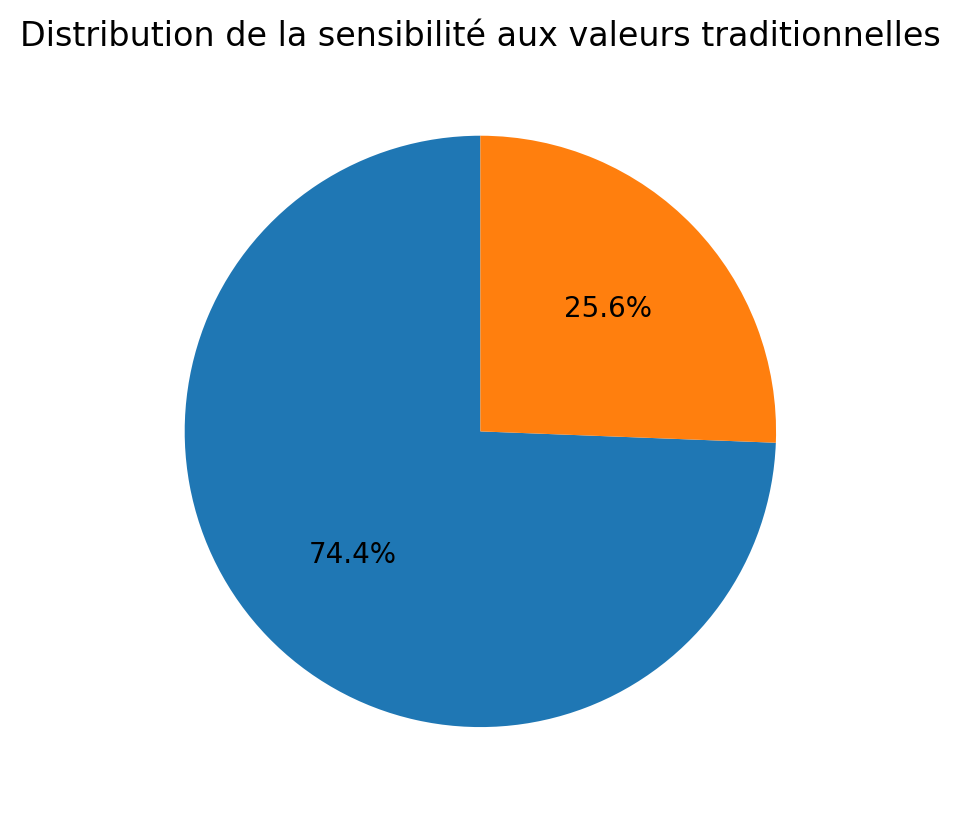

In [484]:
# 1. Distribution de la variable cible
plt.subplot()
tradition_value_sensibility = data_enough_values[label_name].value_counts()
plt.pie(tradition_value_sensibility.values, autopct='%1.1f%%',
         startangle=90)
plt.title('Distribution de la sensibilité aux valeurs traditionnelles')

print(tradition_value_sensibility)

On supprime le biais lié à la mauvaise distribution du label dans le dataset

Nouvelle dimension du dataset après équilibrage : (231698, 20)
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 231698 entries, ('ESS4e04_6', np.int64(4), np.float64(4.6), '14.11.2023', np.int64(2605), 'PT') to ('ESS6e02_7', np.int64(6), np.float64(2.7), '18.08.2025', np.int64(11003941), 'DE')
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ppltrst         230936 non-null  float64
 1   lrscale         199834 non-null  float64
 2   polintr         231111 non-null  float64
 3   trstlgl         226329 non-null  float64
 4   trstplc         229252 non-null  float64
 5   trstplt         227432 non-null  float64
 6   imwbcnt         221361 non-null  float64
 7   rlgdgr          229690 non-null  float64
 8   rlgdnm          223811 non-null  float64
 9   sclmeet         230525 non-null  float64
 10  gndr            231587 non-null  float64
 11  agea            230760 non-null  float64
 12  chldhm          186981

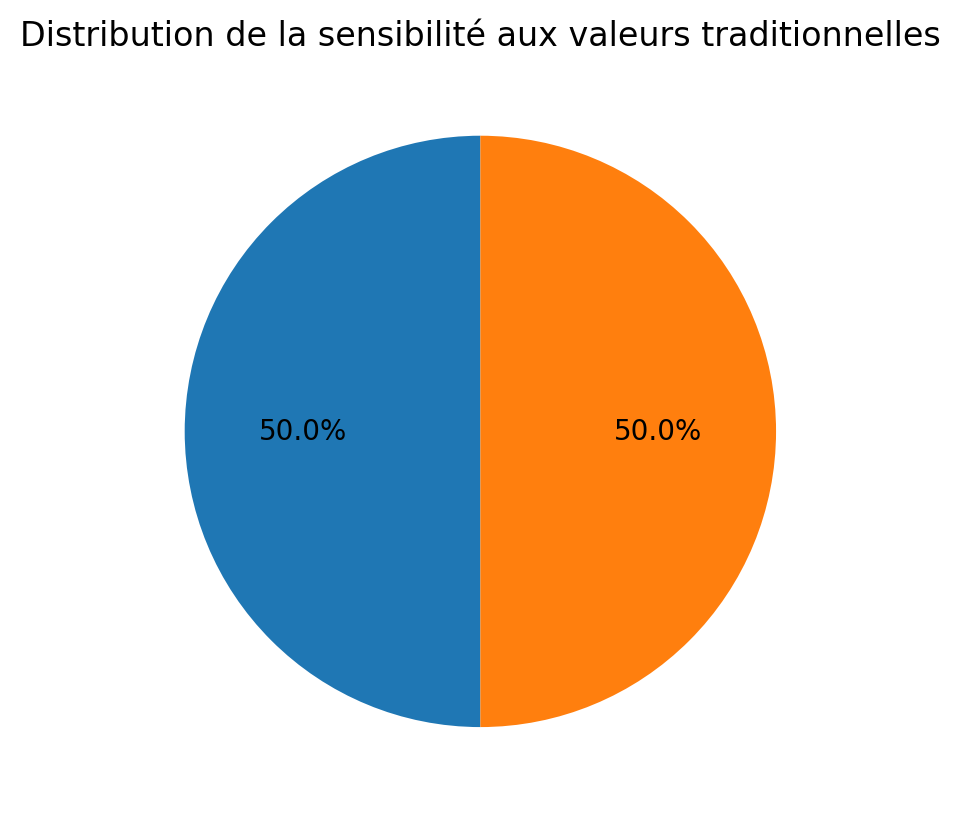

In [485]:
# For each unique value in tradition_value_sensibility, extract 15287 entries from data_z_filtered
balanced_data = pd.DataFrame()
for value in tradition_value_sensibility.index:
    subset = data_enough_values[data_enough_values[label_name] == value].sample(n=np.min(tradition_value_sensibility), replace=True, random_state=42)
    balanced_data = pd.concat([balanced_data, subset])

tradition_value_sensibility_balanced = balanced_data[label_name].value_counts()
plt.pie(tradition_value_sensibility_balanced.values, autopct='%1.1f%%',
        startangle=90)
plt.title('Distribution de la sensibilité aux valeurs traditionnelles')

print(f"Nouvelle dimension du dataset après équilibrage : {balanced_data.shape}")

balanced_data.info()

### Analyse descriptive

Analyse descriptive sur les features numériques pour détecter les éventuels outliers à supprimer

In [486]:
numerical_cols = ['agea', 'chldhm']

print("Analyse descriptive des données numériques")
balanced_data[numerical_cols].describe()

Analyse descriptive des données numériques


,agea,chldhm
count,230760.000000,186981.000000
mean,46.872543,1.629786
std,18.442883,0.482863
min,14.000000,1.000000
25%,32.000000,1.000000
50%,46.000000,2.000000
75%,61.000000,2.000000
max,114.000000,2.000000


In [487]:
print("Analyse descriptive des données catégorielles")
balanced_data.drop(numerical_cols, axis=1).astype(str).describe()


Analyse descriptive des données catégorielles


,ppltrst,lrscale,polintr,trstlgl,trstplc,trstplt,imwbcnt,rlgdgr,rlgdnm,sclmeet,gndr,domicil,emplrel,tporgwk,imptrad,occupation,education,marital_status
count,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698,231698
unique,12,12,5,12,12,12,12,12,10,8,3,6,5,7,2,11,13,6
top,5.0,5.0,2.0,5.0,8.0,5.0,5.0,0.0,66.0,6.0,2.0,3.0,1.0,4.0,0.0,2,0003,1.0
freq,45529,64836,80736,35545,40458,38449,65668,44472,101788,63871,120382,71566,178957,83312,115849,34224,54196,110872


### Matrice de corrélation

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

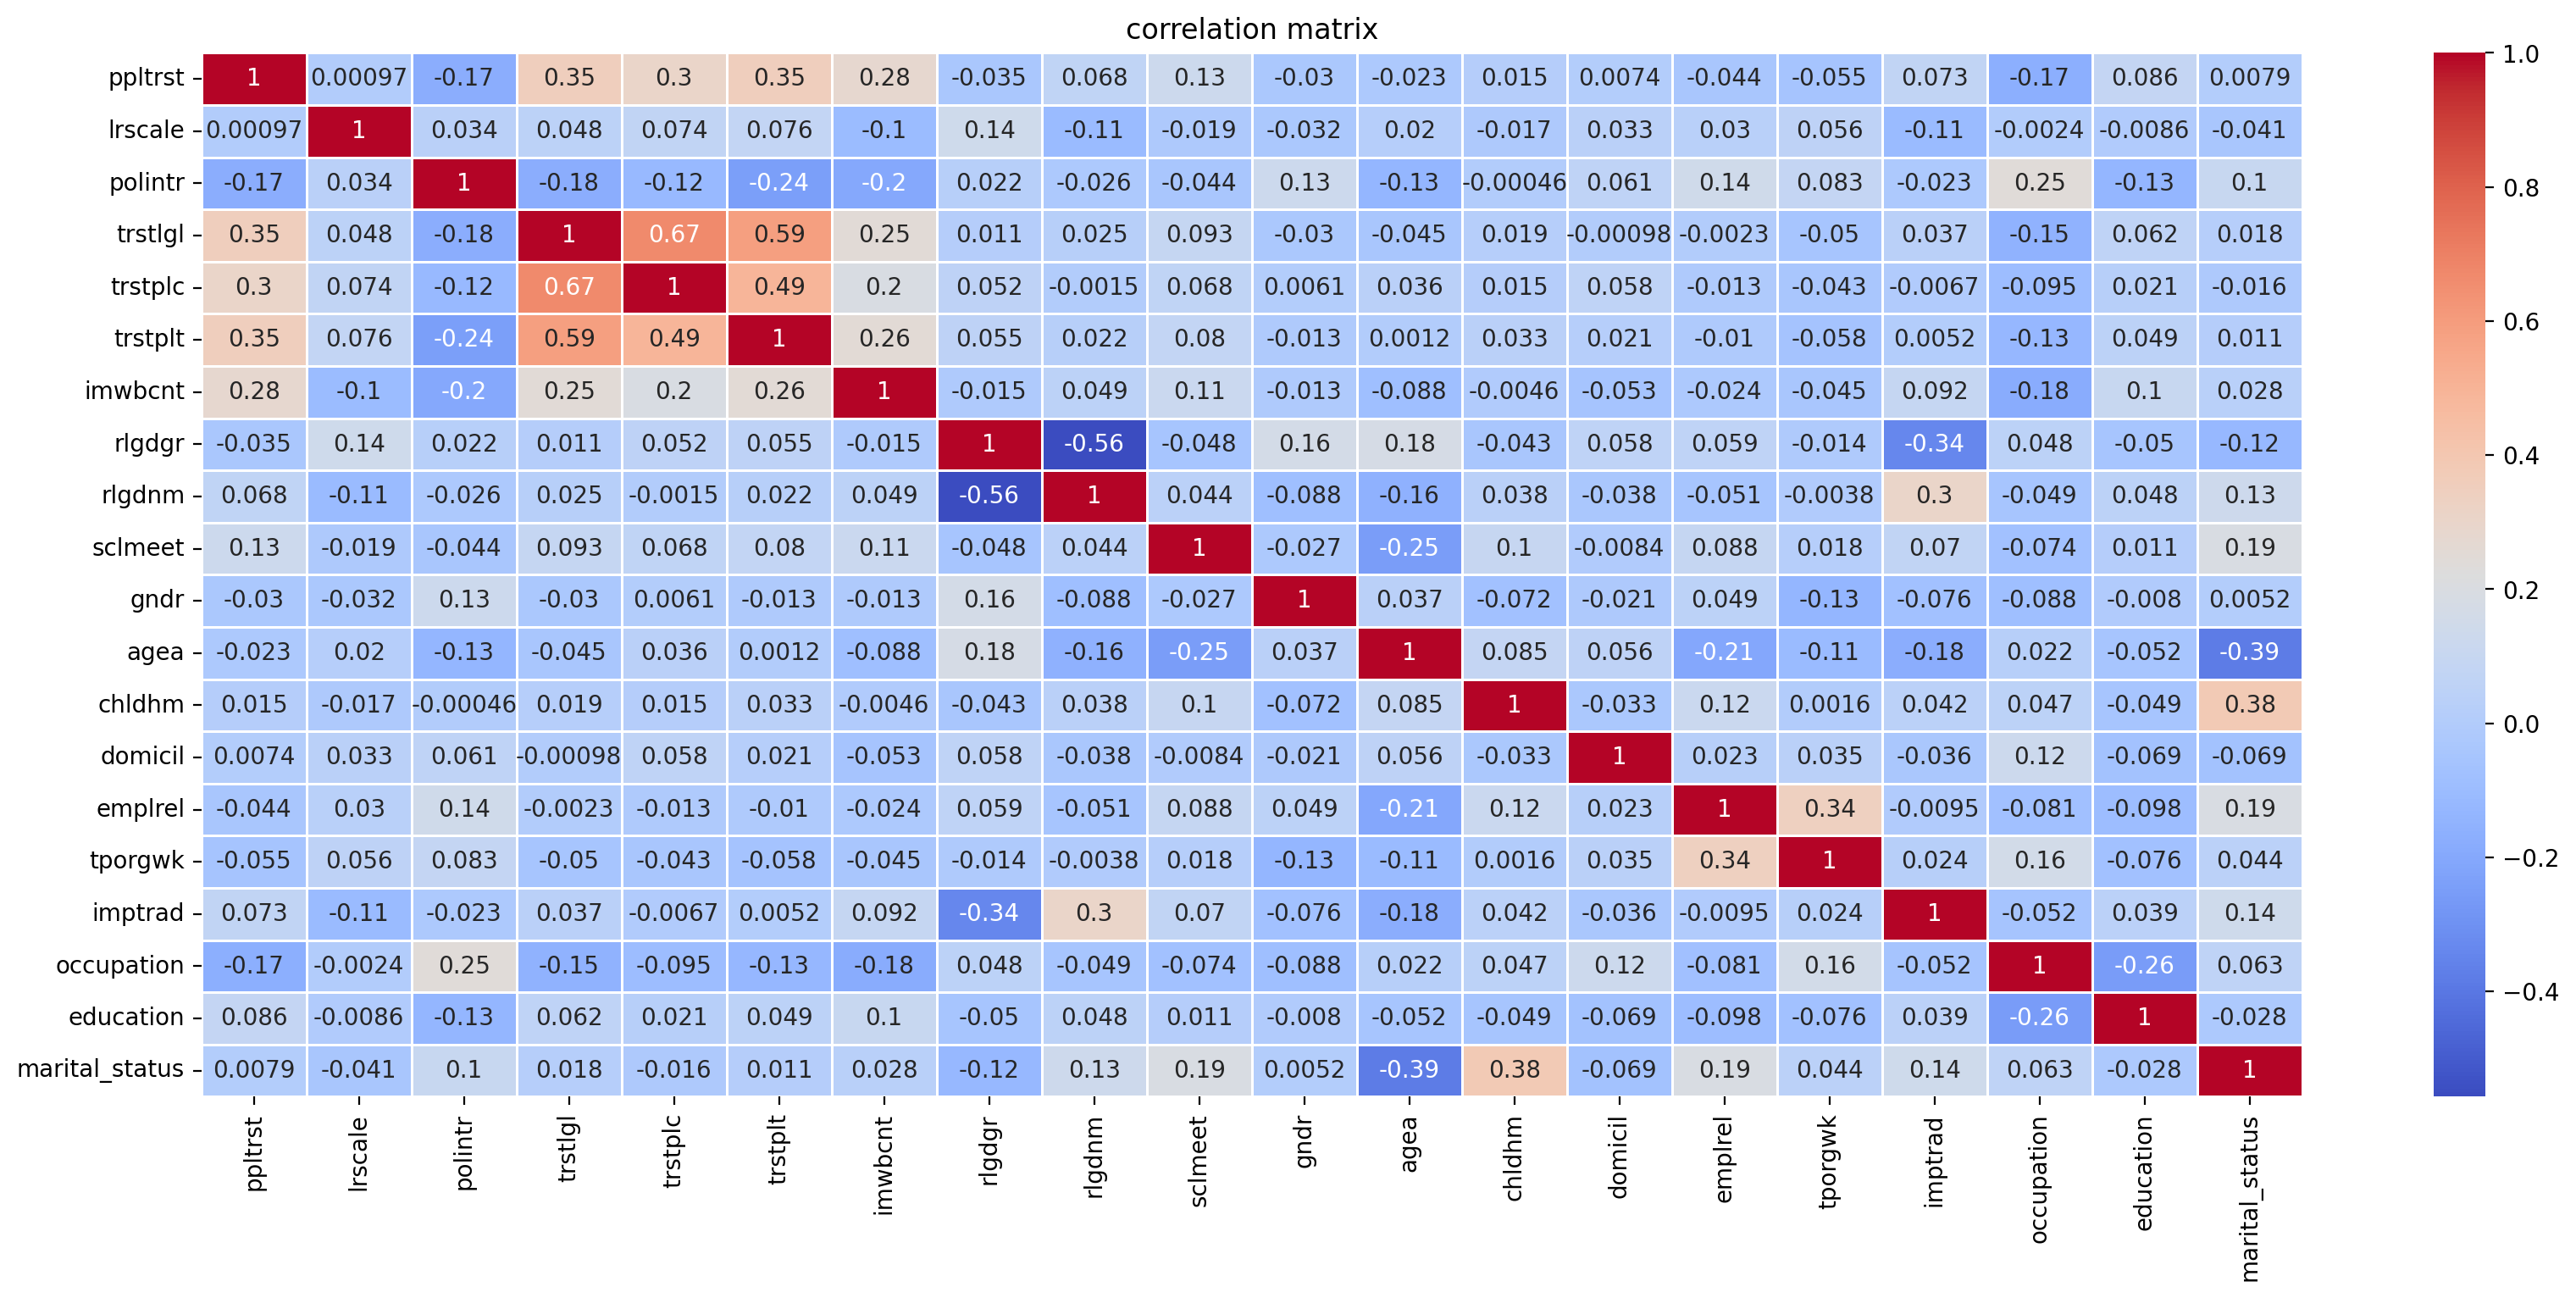

In [499]:
plt.figure(figsize=(20,8))
correlation_matrix = balanced_data.corr()
sns.heatmap(correlation_matrix, annot =True, cmap='coolwarm', linewidths=0.5)
plt.title('correlation matrix')
plt.tight_layout

## Préparation des données d'entrainement

### Séparation des données d'entrainement et de test

In [489]:
X = balanced_data.drop(label_name, axis=1)
y = balanced_data[label_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.head()

ppltrst  lrscale  polintr  \
name       essround edition proddate   idno  cntry                              
ESS10e03_2 10       3.2     02.11.2023 70035 IE         9.0      6.0      2.0   
                                       14083 MK         2.0      NaN      4.0   
ESS7e02_3  7        2.3     23.11.2023 2069  LT         5.0      2.0      3.0   
ESS6e02_7  6        2.7     18.08.2025 12109 BE         7.0      7.0      2.0   
ESS5e03_6  5        3.6     18.08.2025 1892  EE         4.0      5.0      4.0   

                                                    trstlgl  trstplc  trstplt  \
name       essround edition proddate   idno  cntry                              
ESS10e03_2 10       3.2     02.11.2023 70035 IE         6.0      7.0      6.0   
                                       14083 MK         0.0      0.0      0.0   
ESS7e02_3  7        2.3     23.11.2023 2069  LT         3.0      3.0      2.0   
ESS6e02_7  6        2.7     18.08.2025 12109 BE         4.0      7.0      1.0   
ESS5e03_6  5        3.6     18.08.2025 1892  EE         8.0      9.0      2.0   

                                                    imwbcnt  rlgdgr  rlgdnm  \
name       essround edition proddate   idno  cntry                            
ESS10e03_2 10       3.2     02.11.2023 70035 IE         6.0     0.0    66.0   
                                       14083 MK         1.0    10.0     3.0   
ESS7e02_3  7        2.3     23.11.2023 2069  LT         4.0     6.0     1.0   
ESS6e02_7  6        2.7     18.08.2025 12109 BE         4.0     0.0    66.0   
ESS5e03_6  5        3.6     18.08.2025 1892  EE         5.0     7.0    66.0   

                                                    sclmeet  gndr  agea  \
name       essround edition proddate   idno  cntry                        
ESS10e03_2 10       3.2     02.11.2023 70035 IE         6.0   1.0  36.0   
                                       14083 MK         4.0   2.0  75.0   
ESS7e02_3  7        2.3     23.11.2023 2069  LT         2.0   2.0  75.0   
ESS6e02_7  6        2.7     18.08.2025 12109 BE         5.0   1.0  47.0   
ESS5e03_6  5        3.6     18.08.2025 1892  EE         5.0   2.0  46.0   

                                                    chldhm  domicil  emplrel  \
name       essround edition proddate   idno  cntry                             
ESS10e03_2 10       3.2     02.11.2023 70035 IE        NaN      3.0      1.0   
                                       14083 MK        NaN      4.0      6.0   
ESS7e02_3  7        2.3     23.11.2023 2069  LT        2.0      4.0      1.0   
ESS6e02_7  6        2.7     18.08.2025 12109 BE        1.0      4.0      1.0   
ESS5e03_6  5        3.6     18.08.2025 1892  EE        2.0      3.0      2.0   

                                                    tporgwk occupation  \
name       essround edition proddate   idno  cntry                       
ESS10e03_2 10       3.2     02.11.2023 70035 IE         2.0          2   
                                       14083 MK         NaN        NaN   
ESS7e02_3  7        2.3     23.11.2023 2069  LT         3.0          5   
ESS6e02_7  6        2.7     18.08.2025 12109 BE         4.0          3   
ESS5e03_6  5        3.6     18.08.2025 1892  EE         4.0          5   

                                                   education  marital_status  
name       essround edition proddate   idno  cntry                            
ESS10e03_2 10       3.2     02.11.2023 70035 IE         0005             1.0  
                                       14083 MK         0002             4.0  
ESS7e02_3  7        2.3     23.11.2023 2069  LT         0004             1.0  
ESS6e02_7  6        2.7     18.08.2025 12109 BE         0004             1.0  
ESS5e03_6  5        3.6     18.08.2025 1892  EE         0003             1.0

### Imputation

In [490]:
def data_imputation(X : pd.DataFrame) -> pd.DataFrame :
    numerical_cols = ['agea', 'chldhm']
    categorical_cols = X.drop(numerical_cols, axis=1).columns

    numerical_imputer = SimpleImputer(strategy='mean')
    categorical_imputer = SimpleImputer(strategy='most_frequent')

    data_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X[numerical_cols]), columns=numerical_cols)
    data_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X[categorical_cols]), columns=categorical_cols)

    return pd.concat([data_numerical_imputed, data_categorical_imputed], axis=1)



X_train_imputed = data_imputation(X_train)

X_train_imputed.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185358 entries, 0 to 185357
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   agea            185358 non-null  float64
 1   chldhm          185358 non-null  float64
 2   ppltrst         185358 non-null  object 
 3   lrscale         185358 non-null  object 
 4   polintr         185358 non-null  object 
 5   trstlgl         185358 non-null  object 
 6   trstplc         185358 non-null  object 
 7   trstplt         185358 non-null  object 
 8   imwbcnt         185358 non-null  object 
 9   rlgdgr          185358 non-null  object 
 10  rlgdnm          185358 non-null  object 
 11  sclmeet         185358 non-null  object 
 12  gndr            185358 non-null  object 
 13  domicil         185358 non-null  object 
 14  emplrel         185358 non-null  object 
 15  tporgwk         185358 non-null  object 
 16  occupation      185358 non-null  object 
 17  education 

### Outiliers detection

In [491]:
def remove_outliers(X: pd.DataFrame, y: pd.DataFrame) -> list[pd.DataFrame] :
    numerical_cols = ['agea', 'chldhm']
    categorical_cols = X.drop(numerical_cols, axis=1).columns
    z_scores = stats.zscore(X[numerical_cols])
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 2).all(axis=1)
    X_z_filtered = X[filtered_entries]
    y_z_filtered = y[filtered_entries]
    print(f"Outliers détectés par Z-Score: {(~filtered_entries).sum()} observations")
    print(f"Nouvelles dimensions X: {X_z_filtered.shape}")
    print(f"Nouvelles dimensions y: {y_z_filtered.shape}")
    return X_z_filtered, y_z_filtered

X_train_filtered, y_train_filtered = remove_outliers(X_train_imputed, y_train)

Outliers détectés par Z-Score: 3101 observations
Nouvelles dimensions X: (182257, 19)
Nouvelles dimensions y: (182257,)


### Encodage des données catégorielles

In [492]:
def encode(X: pd.DataFrame, y: pd.DataFrame) -> list[pd.DataFrame] :
    numerical_cols = ['agea', 'chldhm']
    categorical_cols = X.drop(numerical_cols, axis=1).columns

    ordinal_encoder = OrdinalEncoder()
    label_encoder = LabelEncoder()

    categorical_data_encoded = pd.DataFrame(ordinal_encoder.fit_transform(X[categorical_cols].astype(str)), columns=categorical_cols)
    df_encoded = pd.concat([X[numerical_cols].reset_index(drop=True), categorical_data_encoded.reset_index(drop=True)], axis=1).reset_index(drop=True)
    label_encoded = pd.DataFrame(label_encoder.fit_transform(y), columns=pd.DataFrame(y).columns)

    return df_encoded, label_encoded


X_train_encoded, y_train_encoded = encode(X_train_imputed, y_train)

y_train_encoded

,imptrad
0,1
1,0
2,1
3,0
4,1
...,...
185353,1
185354,0
185355,1
185356,1


### Normalisation

In [493]:
def normalize(X: pd.DataFrame, y: pd.DataFrame) -> list[pd.DataFrame] :
    scaler = StandardScaler()
    X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    y_normalized = pd.DataFrame(scaler.fit_transform(y), columns=y.columns)
    return X_normalized, y_normalized

X_train_scaled, y_train_scaled = normalize(X_train_encoded, y_train_encoded)

y_train_scaled

,imptrad
0,1.001760
1,-0.998243
2,1.001760
3,-0.998243
4,1.001760
...,...
185353,1.001760
185354,-0.998243
185355,1.001760
185356,1.001760


## Choix du modèle

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


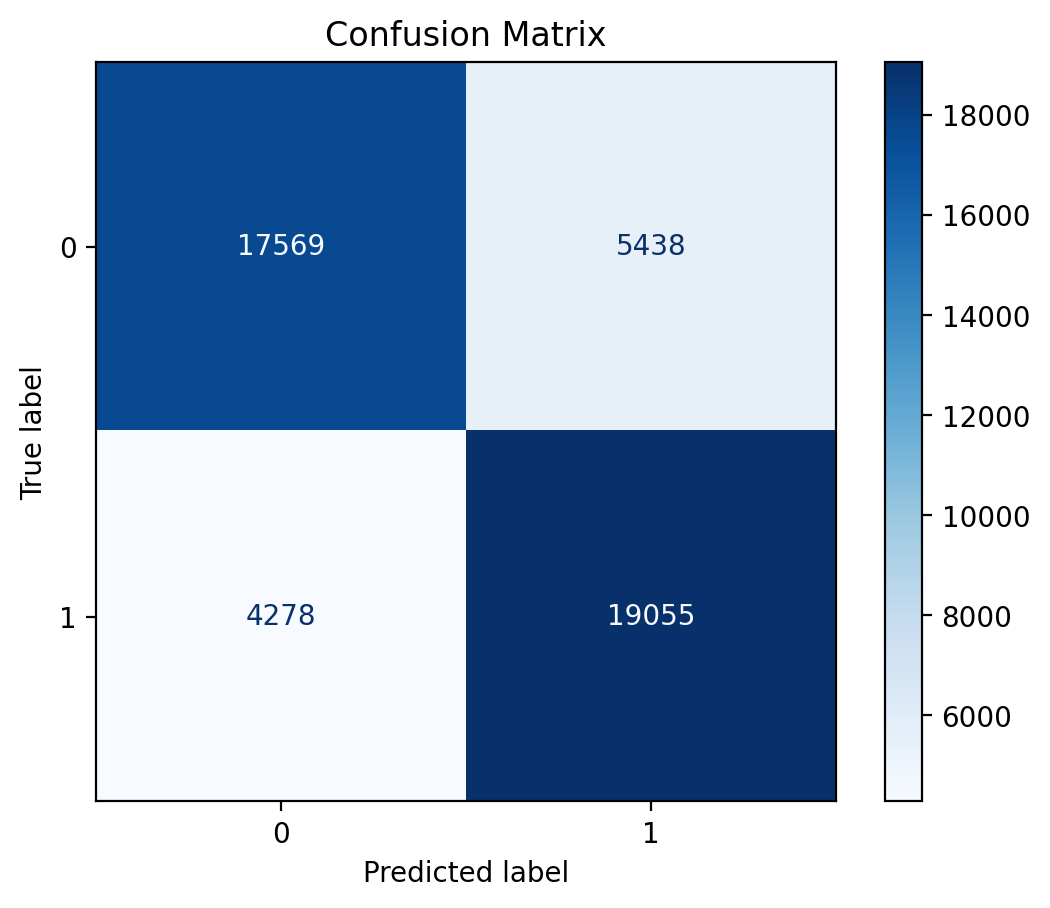

Accuracy : 0.7903323262839879


In [496]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

# Identification des paramètres
#parameters = {'loss':('ls', 'lad', 'huber', 'quantile')}
rfc_parameters = {
    'max_depth' : (5,10,20),
    'criterion' : ('entropy', 'gini'),
    'n_estimators' : (50,100,200)
}

# Initialisation du modèle
#gbt = GradientBoostingRegressor()
#rfc = RandomForestClassifier(random_state=123)
#model = GridSearchCV(rfc, rfc_parameters)

# Gridsearch
#model = GridSearchCV(gbt, parameters)

#model = LogisticRegression()
#model = SVC()
model = RandomForestClassifier(max_depth=20, criterion='entropy', n_estimators=200, random_state=123)
#weak_learner = LogisticRegression()
#model = AdaBoostClassifier(estimator=weak_learner, n_estimators=50, learning_rate=0.5, random_state=123)

model.fit(X_train_scaled, y_train_encoded)

#y_train_pred = model.best_estimator_.predict(X_train_scaled)
y_train_pred = model.predict(X_train_scaled)

X_test_imputed = data_imputation(X_test)
X_test_encoded, y_test_encoded = encode(X_test_imputed, y_test)
X_test_scaled, y_test_scaled = normalize(X_test_encoded, y_test_encoded)

y_pred = model.predict(X_test_scaled)

# Affiche la matrice de confusion:
cm = confusion_matrix(y_test,y_pred)

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


#texte de rapport rapport plus precis de ce qu'on trouve
#print(classification_report(y_test,y_pred))

#print('-------')
print(f"Accuracy : {accuracy_score(y_test,y_pred)}")
#print('-------')

# ROC Curve
# fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1], pos_label=1)

# visualize ROC Curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc_score(y_pred, model.predict_proba(X_test_scaled)[:, 1])))
# plt.plot([0, 1], [0, 1], color='red', linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.show()

